In [2]:
import numpy as np
np.random.seed(42)
import pandas as pd
from scipy.stats import ttest_ind
from numba import njit, jit
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [3]:
meta = pd.read_csv('../data/META_SL.csv')

In [4]:
meta['plat'].unique()

array(['Agilent', 'Illumina_NGS', 'Affymetrix_U133', 'Illumina_Chip',
       'Affymetrix_HUG', 'Affymetrix_PRV'], dtype=object)

In [5]:
meta

,CN,type,plat,TP
0,C_1,Solid tumor,Agilent,Solid tumor_Agilent
1,C_2,Solid tumor,Agilent,Solid tumor_Agilent
2,C_3,Solid tumor,Agilent,Solid tumor_Agilent
3,C_4,Solid tumor,Agilent,Solid tumor_Agilent
4,C_5,Solid tumor,Agilent,Solid tumor_Agilent
...,...,...,...,...
7162,C_7163,C,Affymetrix_PRV,C_Affymetrix_PRV
7163,C_7164,D,Affymetrix_PRV,D_Affymetrix_PRV
7164,C_7165,D,Affymetrix_PRV,D_Affymetrix_PRV
7165,C_7166,D,Affymetrix_PRV,D_Affymetrix_PRV


#### Данные, на которых нужно проверить гипотезу

In [6]:
data = pd.read_csv('../data/41.csv')

In [7]:
data.head()

,S9bcbf828_bd0c_4a71_8021_7a262de8978c,S23ea1a02_938c_47cc_8a7d_abd33db1f305,Sddfe7bdf_0d22_4f98_b712_09df67794990,Sb80aec3c_742c_4e9d_b45b_53809b6b80f1,S988b3794_2640_4ff6_a739_d473adbca3e8,S5d095a36_74db_44ec_bca2_35af7a47f1c5,S97e6b861_062c_4235_8f12_db621f22e353,S9120d8d8_8605_493d_a963_7642852778c4,S10aa11ee_6df1_42f6_bc32_6ffed2e7d25c,S3e1fc047_a69e_469b_a005_33b208fdbfd3,...,AFX_GPL16043_B_3,AFX_GPL16043_B_4,AFX_GPL16043_C_1,AFX_GPL16043_C_2,AFX_GPL16043_C_3,AFX_GPL16043_C_4,AFX_GPL16043_D_1,AFX_GPL16043_D_2,AFX_GPL16043_D_3,AFX_GPL16043_D_4
A2M,71.942985,31.600640,23.719099,165.132989,132.866707,38.830108,67.970526,58.557534,95.046693,9.817758,...,115.620414,101.602110,99.487770,150.091873,142.735481,175.210202,105.011295,115.032856,101.556111,113.950576
AAMP,12.616553,9.835604,10.653960,13.974929,42.009487,9.466674,9.786993,9.361648,20.222985,56.675819,...,17.413527,16.920375,9.367645,12.630448,11.199459,12.941732,10.223784,9.715582,12.746229,16.998072
ABCF3,43.282523,34.870175,25.766479,17.029958,50.098038,27.783870,49.079378,49.140569,40.376099,51.658344,...,23.925121,21.032493,18.056313,17.485692,18.630898,18.119417,20.473326,18.819747,18.428061,19.305809
ABCG1,6.508482,6.289110,5.840161,6.578096,6.402853,5.155252,5.232662,5.960112,6.162625,8.165335,...,7.918250,8.077194,6.804909,7.316594,6.883861,6.969536,6.942066,6.282369,7.004586,6.338942
ABHD2,3.094181,3.405606,3.300960,3.199570,4.335736,2.997598,3.352664,3.127601,3.717021,3.760651,...,7.319039,7.764805,8.758344,7.928251,7.887156,8.009493,7.920969,8.641963,7.849066,8.219164


In [8]:
data.columns = meta['CN']

In [9]:
data.head()

CN,C_1,C_2,C_3,C_4,C_5,C_6,C_7,C_8,C_9,C_10,...,C_7158,C_7159,C_7160,C_7161,C_7162,C_7163,C_7164,C_7165,C_7166,C_7167
A2M,71.942985,31.600640,23.719099,165.132989,132.866707,38.830108,67.970526,58.557534,95.046693,9.817758,...,115.620414,101.602110,99.487770,150.091873,142.735481,175.210202,105.011295,115.032856,101.556111,113.950576
AAMP,12.616553,9.835604,10.653960,13.974929,42.009487,9.466674,9.786993,9.361648,20.222985,56.675819,...,17.413527,16.920375,9.367645,12.630448,11.199459,12.941732,10.223784,9.715582,12.746229,16.998072
ABCF3,43.282523,34.870175,25.766479,17.029958,50.098038,27.783870,49.079378,49.140569,40.376099,51.658344,...,23.925121,21.032493,18.056313,17.485692,18.630898,18.119417,20.473326,18.819747,18.428061,19.305809
ABCG1,6.508482,6.289110,5.840161,6.578096,6.402853,5.155252,5.232662,5.960112,6.162625,8.165335,...,7.918250,8.077194,6.804909,7.316594,6.883861,6.969536,6.942066,6.282369,7.004586,6.338942
ABHD2,3.094181,3.405606,3.300960,3.199570,4.335736,2.997598,3.352664,3.127601,3.717021,3.760651,...,7.319039,7.764805,8.758344,7.928251,7.887156,8.009493,7.920969,8.641963,7.849066,8.219164


In [10]:
data = data.astype(float)

In [11]:
data.head()

CN,C_1,C_2,C_3,C_4,C_5,C_6,C_7,C_8,C_9,C_10,...,C_7158,C_7159,C_7160,C_7161,C_7162,C_7163,C_7164,C_7165,C_7166,C_7167
A2M,71.942985,31.600640,23.719099,165.132989,132.866707,38.830108,67.970526,58.557534,95.046693,9.817758,...,115.620414,101.602110,99.487770,150.091873,142.735481,175.210202,105.011295,115.032856,101.556111,113.950576
AAMP,12.616553,9.835604,10.653960,13.974929,42.009487,9.466674,9.786993,9.361648,20.222985,56.675819,...,17.413527,16.920375,9.367645,12.630448,11.199459,12.941732,10.223784,9.715582,12.746229,16.998072
ABCF3,43.282523,34.870175,25.766479,17.029958,50.098038,27.783870,49.079378,49.140569,40.376099,51.658344,...,23.925121,21.032493,18.056313,17.485692,18.630898,18.119417,20.473326,18.819747,18.428061,19.305809
ABCG1,6.508482,6.289110,5.840161,6.578096,6.402853,5.155252,5.232662,5.960112,6.162625,8.165335,...,7.918250,8.077194,6.804909,7.316594,6.883861,6.969536,6.942066,6.282369,7.004586,6.338942
ABHD2,3.094181,3.405606,3.300960,3.199570,4.335736,2.997598,3.352664,3.127601,3.717021,3.760651,...,7.319039,7.764805,8.758344,7.928251,7.887156,8.009493,7.920969,8.641963,7.849066,8.219164


#### Код Стьюдента

In [12]:
rng = np.random.default_rng()

In [13]:
def get_splitted_columns(columns):
    shuffled = rng.permutation(columns)
    columns_1 = shuffled[:len(columns) // 2]
    columns_2 = shuffled[len(columns) // 2:]
    return columns_1, columns_2

In [14]:
def split_for_f(gene, columns_1, columns_2):
    sample_1 = gene[columns_1].values
    sample_2 = gene[columns_2].values
    return f(sample_1, sample_2)

$$
f_g = sign(\overline{D}_g - \overline{H}_g) \cdot (-lg(P_g))
$$

In [15]:
# @njit
def f(sample_1, sample_2):
    sign = np.sign(sample_1.mean() - sample_2.mean())
    p_value = ttest_ind(sample_1, sample_2)[1]
    return sign * (-np.log1p(p_value))

In [16]:
def calc_corr(data, fixed_cols, splitting_cols):
    cols_1, cols_2 = get_splitted_columns(splitting_cols)
    
    f_1 = data.apply(split_for_f, args=(fixed_cols, cols_1), axis=1)
    f_2 = data.apply(split_for_f, args=(fixed_cols, cols_2), axis=1)
    
    return f_1.corr(f_2)

In [18]:
# %time calc_corr(data, plat_1, plat_2)

#### Перебор всех пар платформ

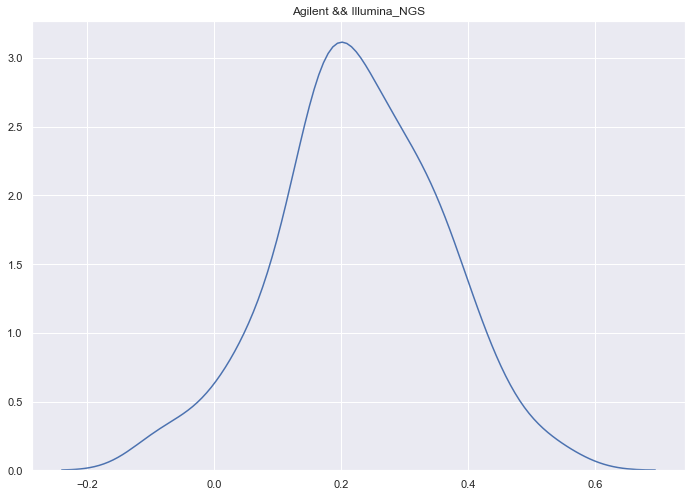

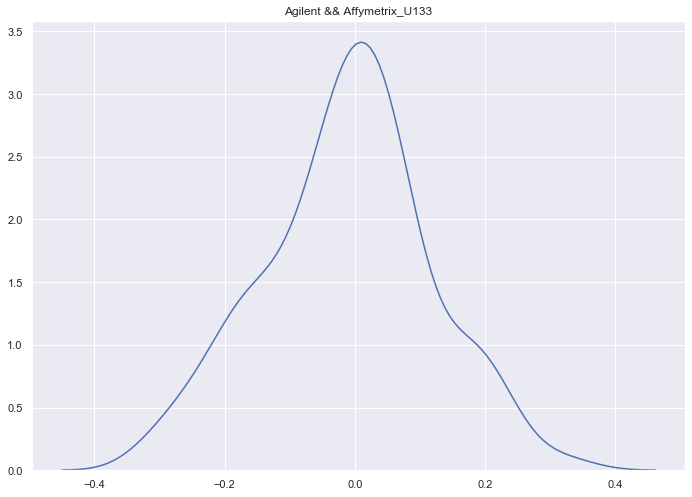

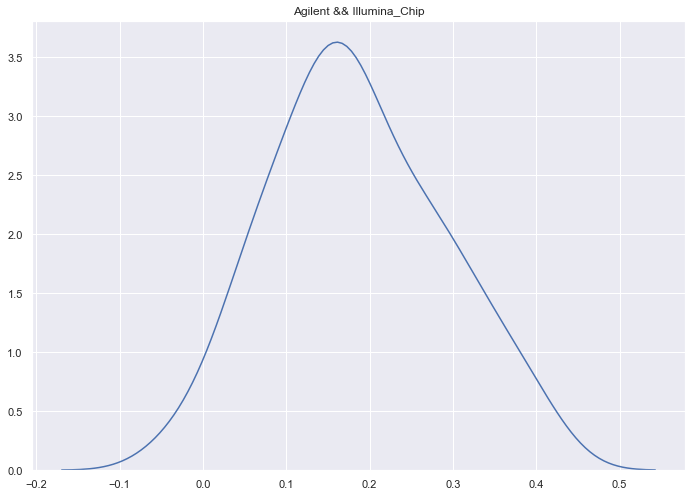

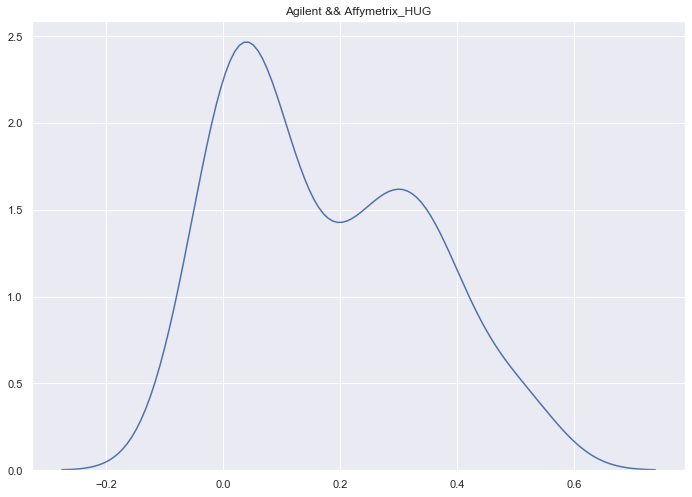

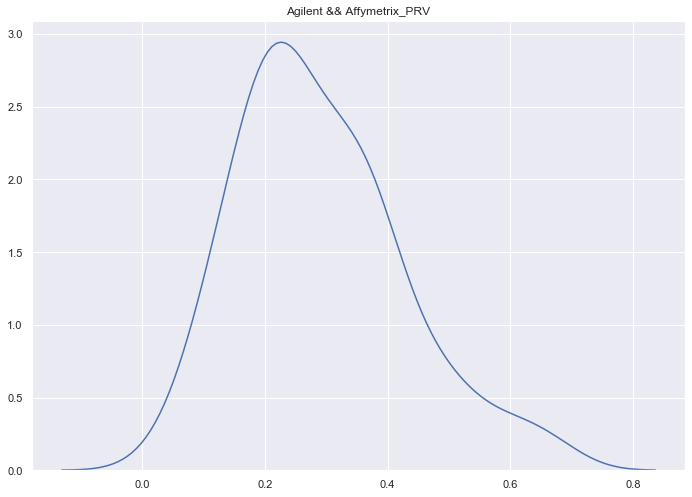

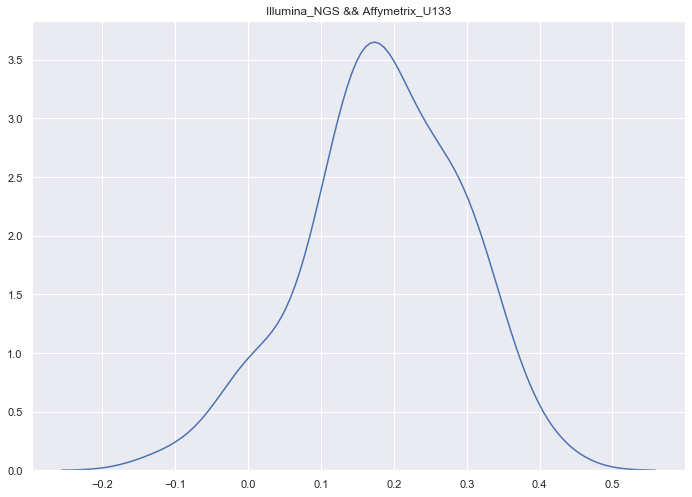

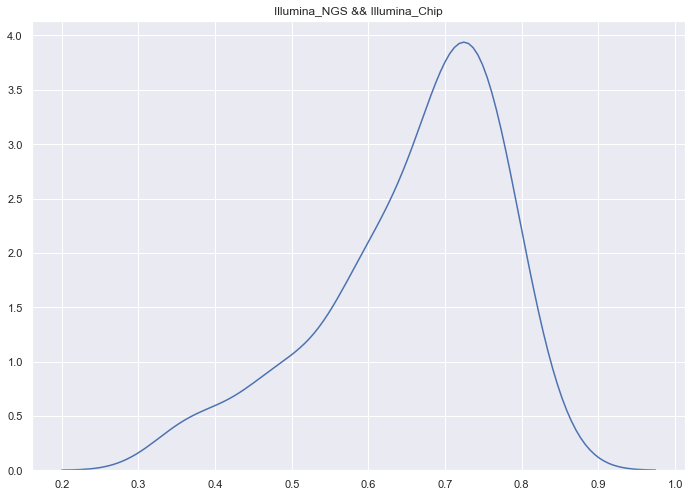

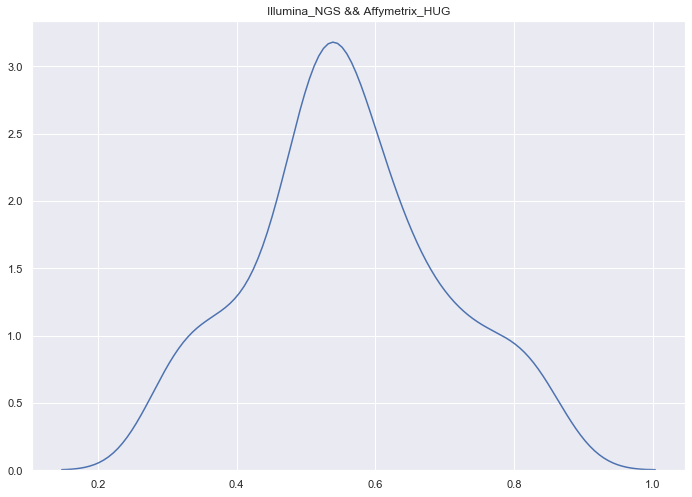

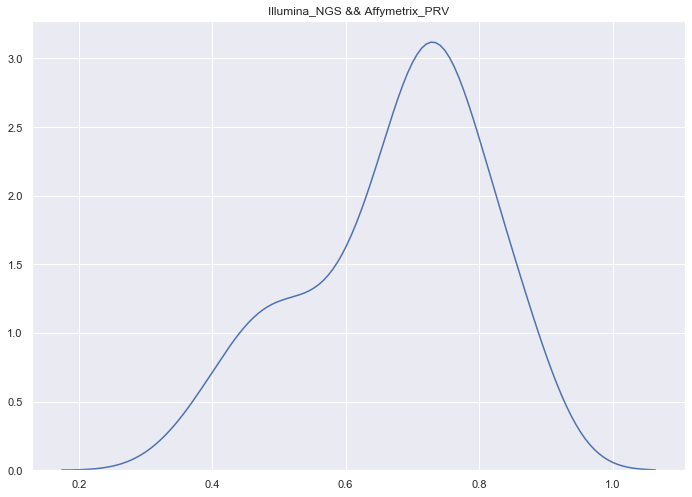

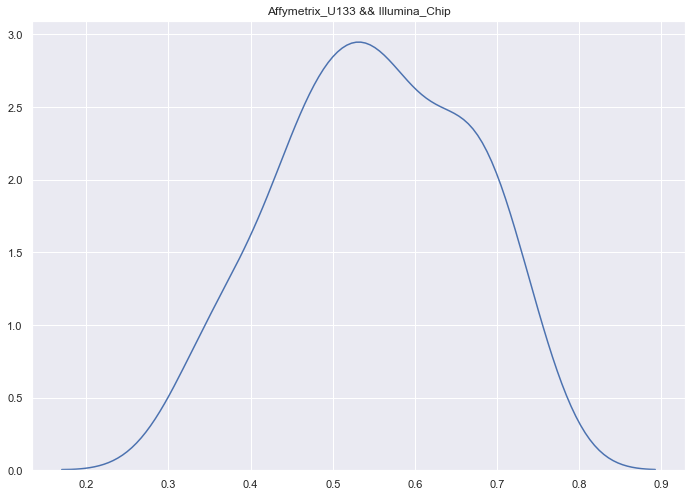

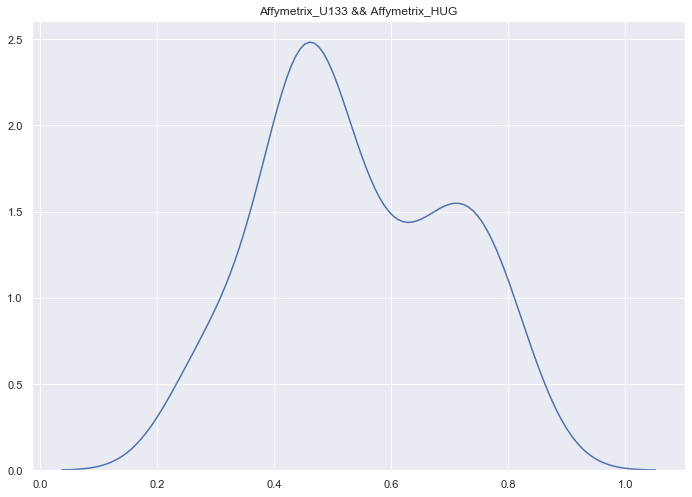

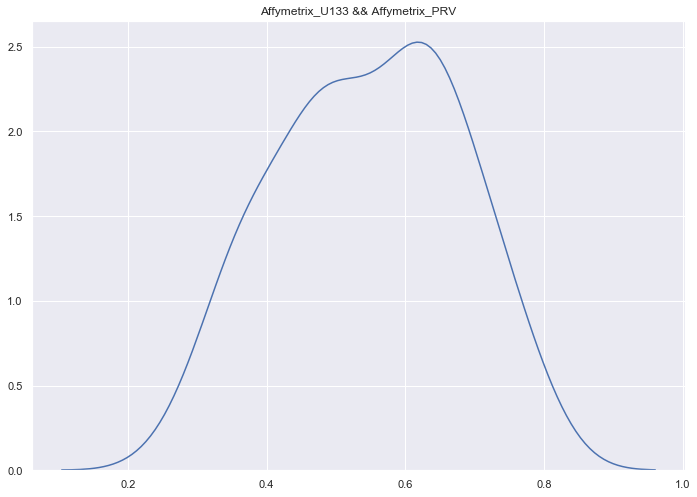

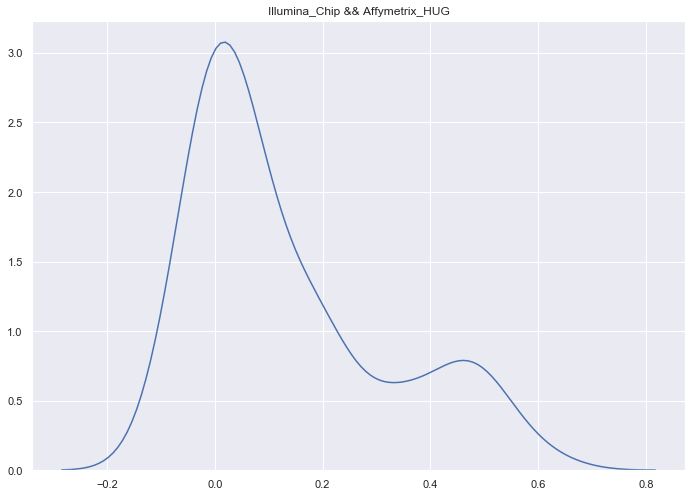

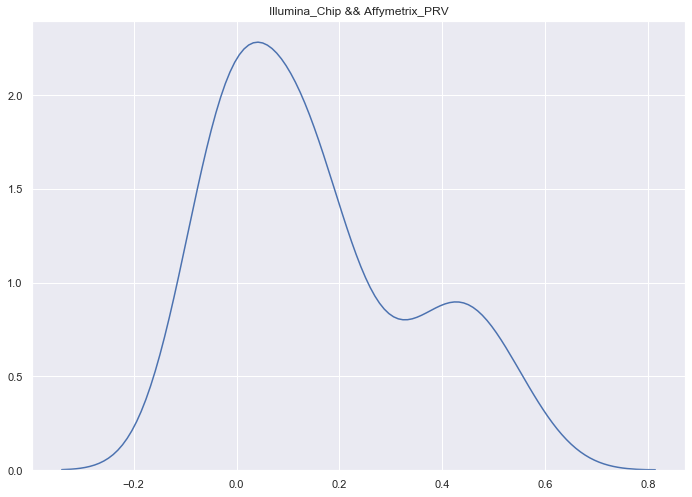

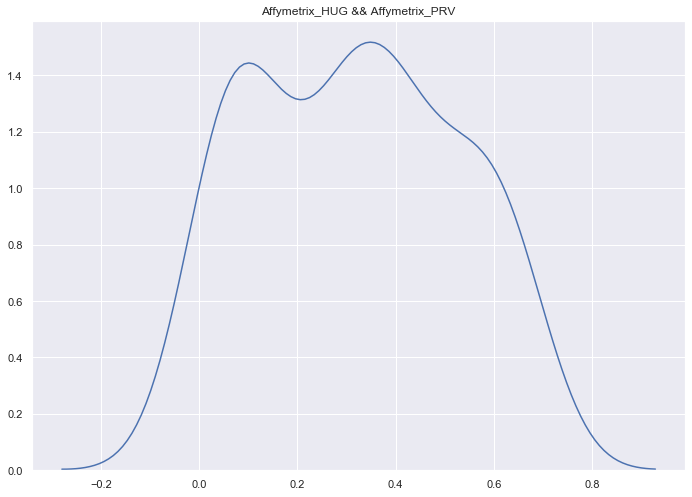

In [19]:
for idx_1, title_1 in enumerate(meta['plat'].unique()):
    for idx_2, title_2 in enumerate(meta['plat'].unique()):
        
        if(idx_2 > idx_1):
            
            plat_1 = meta[meta['plat'] == title_1]['CN']
            plat_2 = meta[meta['plat'] ==  title_2]['CN']
            
            corrs = [calc_corr(data, plat_1, plat_2) for i in range(100)]
            
            plt.figure()
            plt.title(title_1 + " && " + title_2)
            sns.distplot(corrs, hist=False)